# AFL Time Series Data Analysis with Result and AFL Fantasy Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("stats.csv")

df.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.00,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.00,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.00,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.00,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.00,...,0,0,8,14,0,0,9,1,0,93


In [3]:
df.dtypes

Team                       object
Player                     object
D.O.B                      object
Height                      int64
Weight                      int64
Position                   object
Season                      int64
Round                      object
Date                       object
Score                     float64
Margin                    float64
WinLoss                    object
Opposition                 object
Venue                      object
Disposals                   int64
Kicks                       int64
Marks                       int64
Handballs                   int64
Goals                       int64
Behinds                     int64
Hitouts                     int64
Tackles                     int64
Rebound50s                  int64
Inside50s                   int64
Clearances                  int64
Clangers                    int64
FreesFor                    int64
FreesAgainst                int64
BrownlowVotes               int64
ContendedPosse

### Creating "Age" column:

In [4]:
#Converting date objects to datetime:
df['D.O.B'] = pd.to_datetime(df['D.O.B'], format='%Y'+'-'+'%m'+'-'+'%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y'+'-'+'%m'+'-'+'%d')

#Creating Age column:
df.insert(2,'Age',(df['Date']-df['D.O.B'])/np.timedelta64(1,'Y'))

df.drop('D.O.B',axis=1,inplace=True)

#Changing WinLoss to numerical values
df.WinLoss.replace(['W', 'L', 'D'],[1,0,.5],inplace=True)

### Fixing Null Values:

In [5]:
#Removing post season "Rounds" (they also have null values)
round_list = ['QF', 'SF', 'PF', 'GF', 'EF']
df = df[~df.Round.isin(round_list)]

### Creating a alphabetically sorted "Team, Opposition" column to be able to group by game:

In [6]:
df['Teams'] = df[['Team','Opposition']].values.tolist()

In [7]:
df.Teams = df.Teams.apply(sorted).apply(', '.join)

### Creating Points Per Percent Played column:

In [8]:
#Creating "points per percent of game played" columns
df.insert(10, 'PointsPerPercentPlayed',(df['Goals']+df['Behinds'])/df['PercentPlayed'])

## Feature info:

In [9]:
df.describe()

,Age,Height,Weight,Season,Score,PointsPerPercentPlayed,Margin,WinLoss,Disposals,Kicks,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
count,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,...,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00
mean,24.96,187.76,88.07,2015.00,88.53,0.01,0.00,0.50,16.73,9.43,...,0.84,0.14,6.40,10.28,0.49,0.53,2.15,0.38,0.40,81.81
std,3.68,7.20,8.08,2.00,27.81,0.02,46.17,0.50,7.21,4.56,...,0.98,0.55,3.71,5.31,0.85,0.99,2.33,0.93,0.68,13.32
min,18.27,167.00,67.00,2012.00,17.00,0.00,-162.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,22.07,183.00,82.00,2013.00,69.00,0.00,-30.00,0.00,11.00,6.00,...,0.00,0.00,4.00,6.00,0.00,0.00,1.00,0.00,0.00,79.00
50%,24.61,187.00,86.00,2015.00,86.00,0.00,0.00,0.50,16.00,9.00,...,1.00,0.00,6.00,10.00,0.00,0.00,1.00,0.00,0.00,84.00
75%,27.49,193.00,93.00,2017.00,106.00,0.02,30.00,1.00,21.00,12.00,...,1.00,0.00,8.00,14.00,1.00,1.00,3.00,0.00,1.00,89.00
max,41.26,211.00,118.00,2018.00,193.00,0.25,162.00,1.00,54.00,36.00,...,8.00,3.00,32.00,40.00,8.00,13.00,25.00,15.00,6.00,100.00


In [10]:
number_list = df.select_dtypes(include=['number']).columns

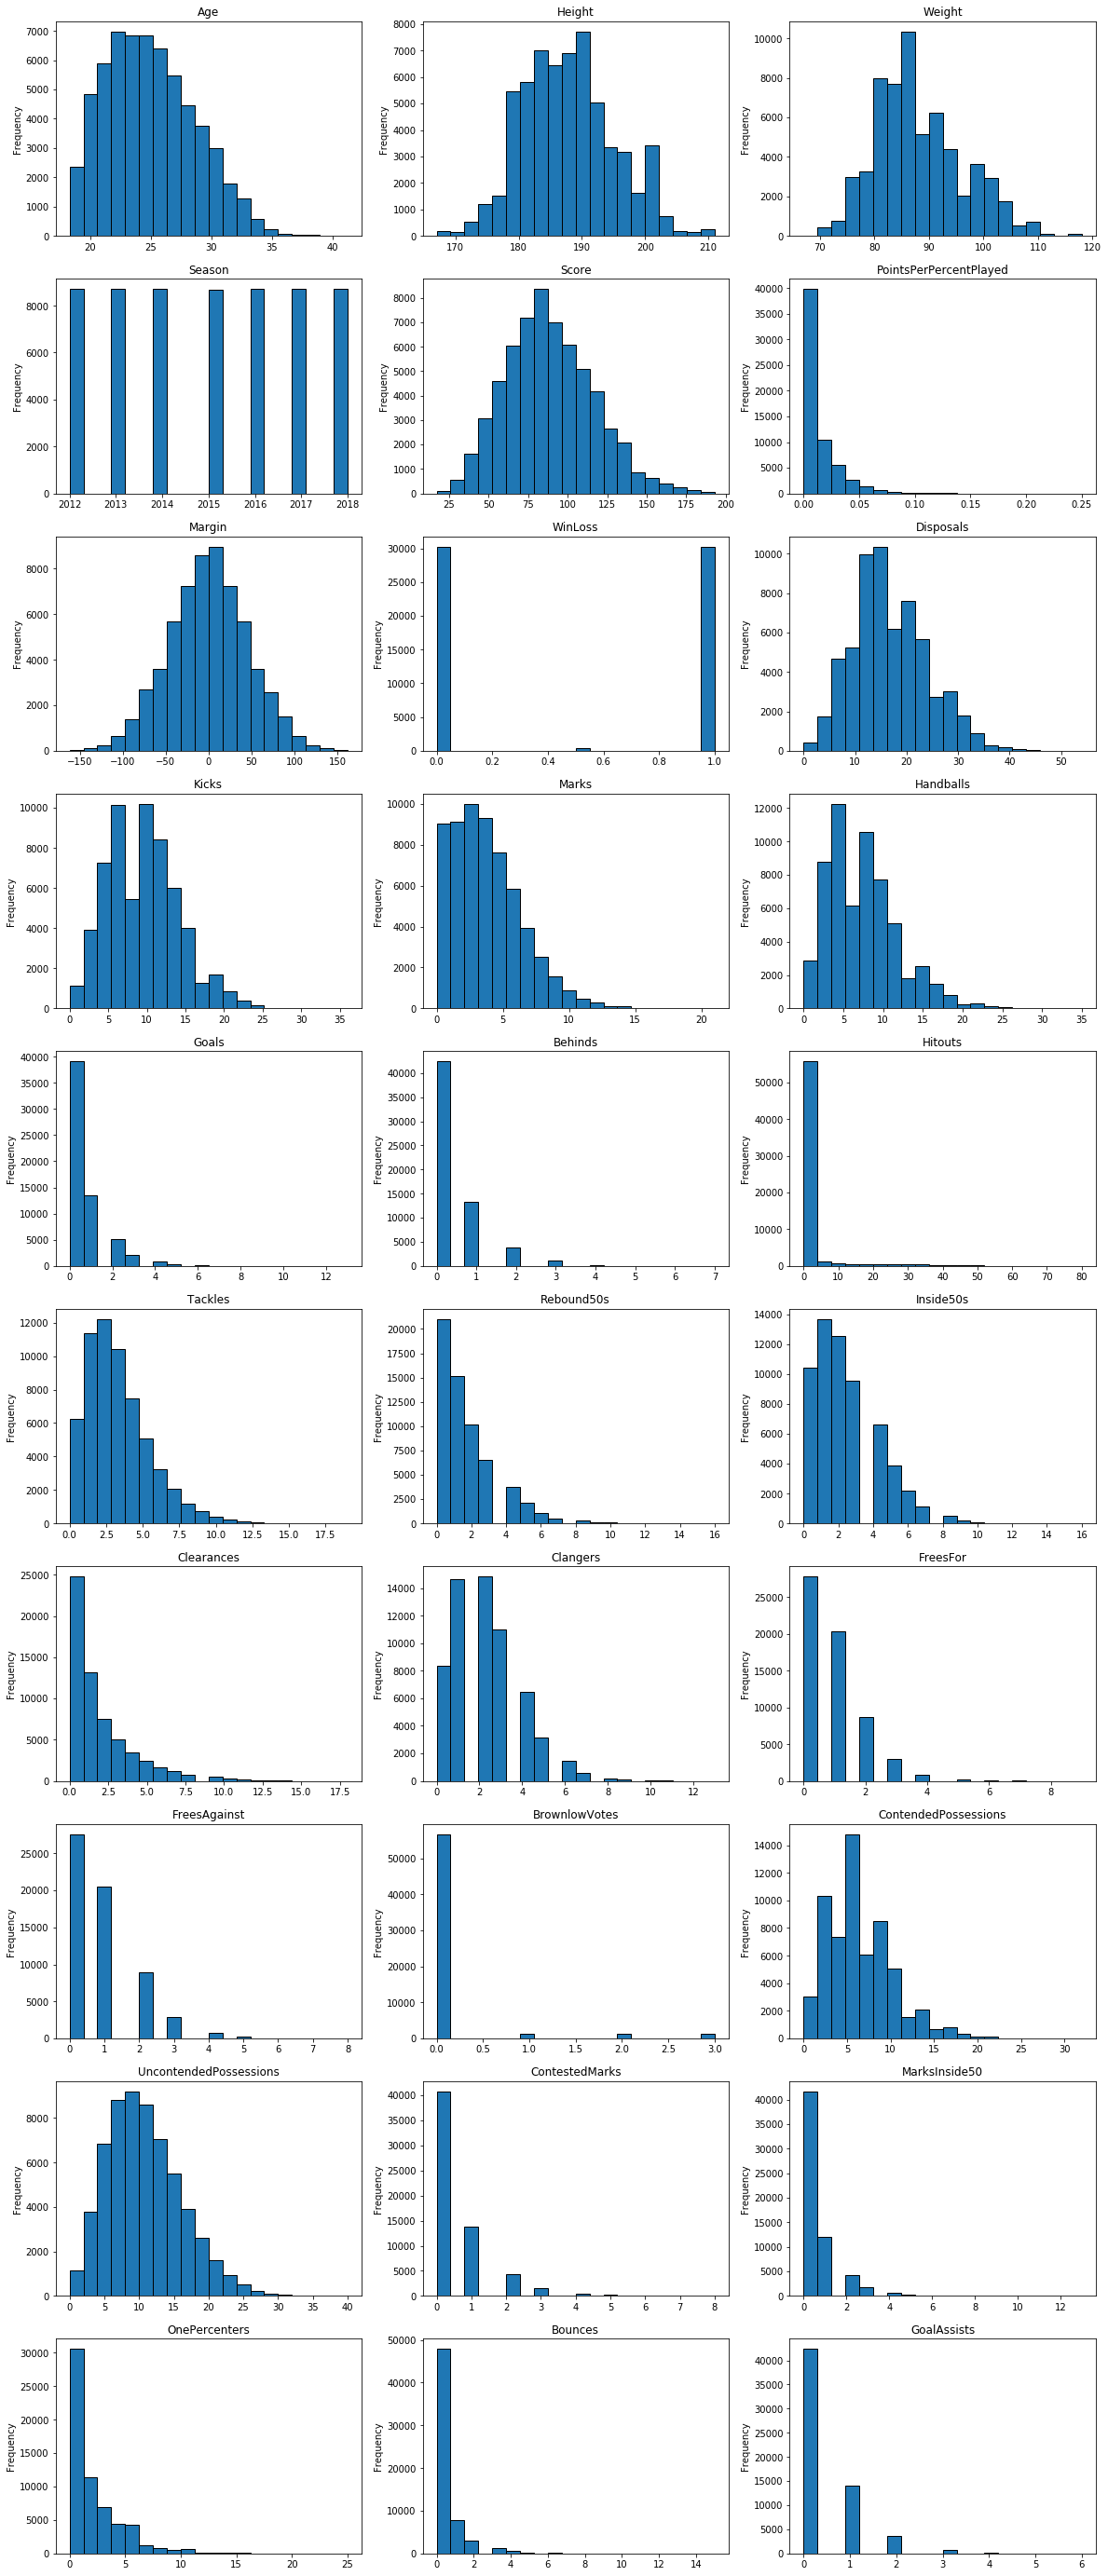

In [11]:
fig,ax = plt.subplots(10, 3)

m=0
for i in range(10):
    for j in range(3):

        df[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],figsize=(20, 50),
                                edgecolor='k').set_title(number_list[m])
        m+=1

In [12]:
df = df.set_index(['Season','Round']).sort_index()

In [13]:
scaling_list = ['PointsPerPercentPlayed','Disposals', 'Kicks', 'Marks','Handballs',
                'Goals', 'Behinds','Hitouts', 'Tackles', 'Rebound50s','Inside50s',
                'Clearances','Clangers', 'FreesFor', 'FreesAgainst','BrownlowVotes',
                'ContendedPossessions', 'UncontendedPossessions','ContestedMarks',
                'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists']

In [14]:
normalize_list = ['Age', 'Height', 'Weight', 'Score', 'Margin']

In [15]:
df_ML = df.copy()

## Normalizing all players by round:

In [16]:
for col in scaling_list:
    df_ML[col] = df_ML.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [17]:
for col in normalize_list:
    df_ML[col] = df_ML.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))

## Normalizing further by game:

In [18]:
df_ML = df_ML.set_index(['Teams'],append=1).sort_index()

In [19]:
for col in scaling_list:
    df_ML[col] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [20]:
for col in normalize_list:
    df_ML[col] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))

In [21]:
df_ML.fillna(0,inplace=True)

In [22]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Season','Round'],axis=1,inplace=True)

df_ML.set_index(['Date','Teams','Team'],inplace=True)
df_ML.sort_index(inplace=True)

# Comparing points made per percent of game to various characteristics relative to players in each game:

## Scaling the data by the percent played:

In [23]:
number_list = scaling_list+normalize_list
number_list

['PointsPerPercentPlayed',
 'Disposals',
 'Kicks',
 'Marks',
 'Handballs',
 'Goals',
 'Behinds',
 'Hitouts',
 'Tackles',
 'Rebound50s',
 'Inside50s',
 'Clearances',
 'Clangers',
 'FreesFor',
 'FreesAgainst',
 'BrownlowVotes',
 'ContendedPossessions',
 'UncontendedPossessions',
 'ContestedMarks',
 'MarksInside50',
 'OnePercenters',
 'Bounces',
 'GoalAssists',
 'Age',
 'Height',
 'Weight',
 'Score',
 'Margin']

In [24]:
df_ML[number_list] = df_ML[number_list].multiply(df_ML.PercentPlayed/100,axis=0)

In [25]:
df_ML[number_list] = df_ML[number_list].groupby(['Date','Teams','Team']).mean()

## Offsetting columns for time series analysis:

In [26]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Player','Position','PercentPlayed','Opposition','Teams'],axis=1,inplace=True)
df_ML.drop_duplicates(inplace=True)

In [27]:
Offset_List = ['Score','PointsPerPercentPlayed','Margin','WinLoss','Disposals',
               'Kicks','Marks','Handballs', 'Goals','Behinds','Hitouts','Tackles',
               'Rebound50s', 'Inside50s', 'Clearances','Clangers','FreesFor',
               'FreesAgainst', 'BrownlowVotes','ContendedPossessions', 
               'UncontendedPossessions', 'ContestedMarks','MarksInside50',
               'OnePercenters', 'Bounces', 'GoalAssists']

In [28]:
PointsList=[]

for column_name in Offset_List:
    df_ML[column_name+'1'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Team')[column_name].shift().reset_index(['Date'], drop=1)

    PointsList.append(column_name+'1')

    for i in range(2,11):
        for i in range(2,11):
            df_ML[column_name+str(i)+'1'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
                .groupby('Team')[column_name].shift(i).reset_index(['Date'], drop=1)

            df_ML[column_name+str(i)] = df_ML.set_index('Date',append=1).sort_index(level=1)\
                .groupby('Team')[column_name].rolling(window=i,min_periods=i).mean()\
                .groupby('Team').shift().reset_index(['Team','Date'], drop=1)
            
            PointsList.append(column_name+str(i)+'1')
            PointsList.append(column_name+str(i)+'2')

In [29]:
Offset_List.remove('WinLoss')

df_ML.drop(Offset_List,axis=1,inplace=True)

In [30]:
#Fixing nulls again because of shifting:
df_ML.dropna(inplace=True)

## Win and Loss Distributions of Features:

In [31]:
df_ML_win = df_ML.select_dtypes(include=['number'])[df_ML.WinLoss==1]

In [32]:
df_ML_loss = df_ML.select_dtypes(include=['number'])[df_ML.WinLoss==0]

In [33]:
number_list = df_ML_win.columns
number_list

Index(['Age', 'Height', 'Weight', 'WinLoss', 'Score1', 'Score21', 'Score2',
       'Score31', 'Score3', 'Score41',
       ...
       'GoalAssists61', 'GoalAssists6', 'GoalAssists71', 'GoalAssists7',
       'GoalAssists81', 'GoalAssists8', 'GoalAssists91', 'GoalAssists9',
       'GoalAssists101', 'GoalAssists10'],
      dtype='object', length=498)

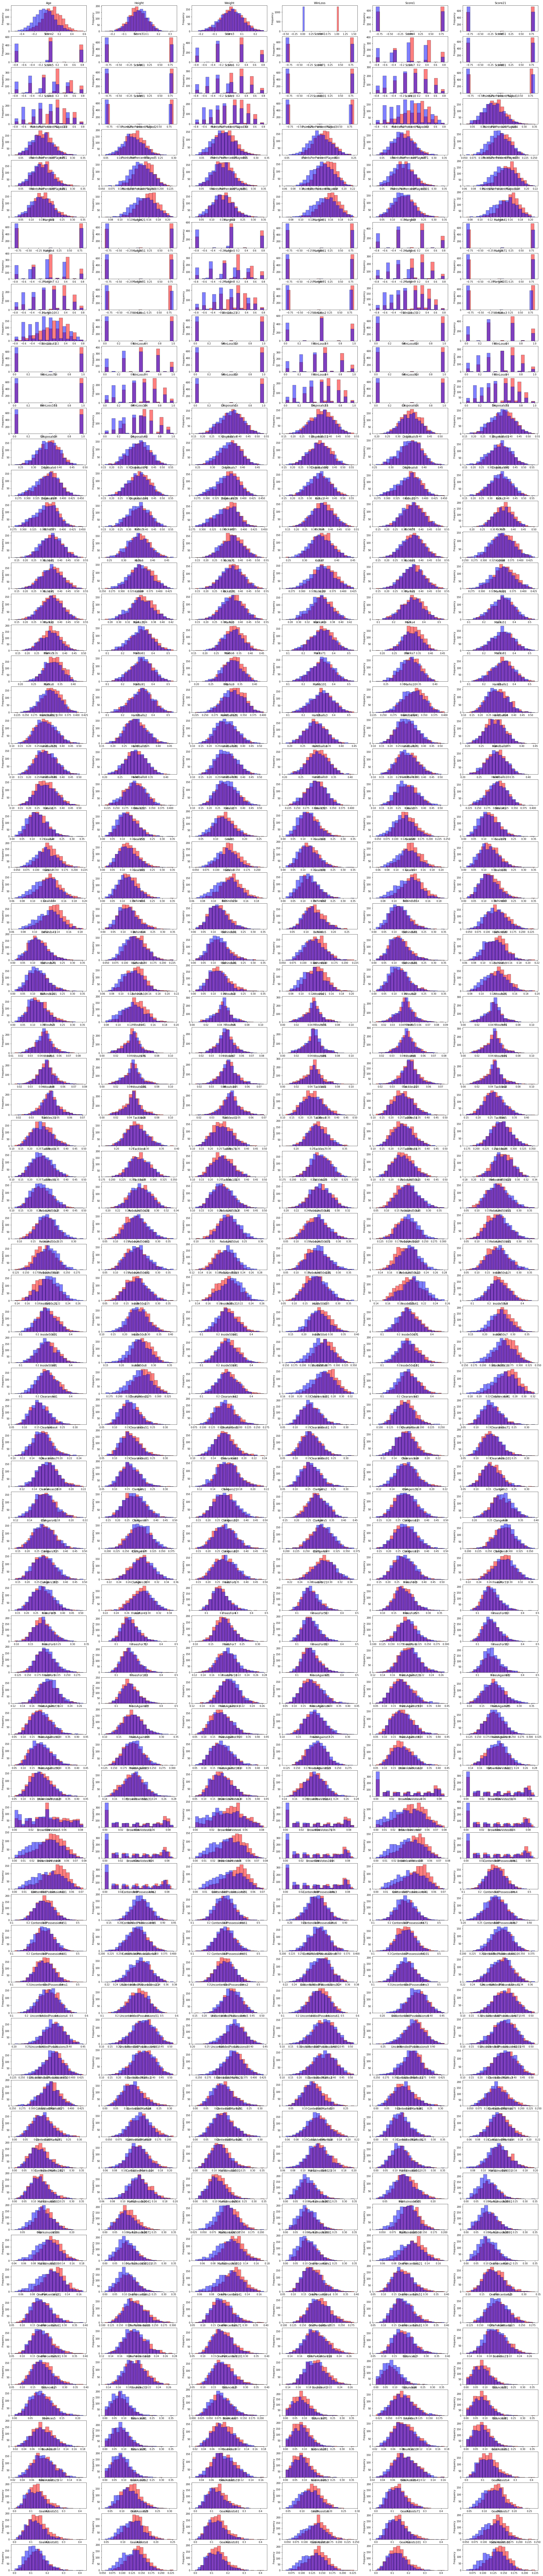

In [34]:
fig,ax = plt.subplots(83, 6)

m=0
for i in range(83):
    for j in range(6):

        df_ML_win[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],
                                       figsize=(40, 200),color='r', alpha=.5,
                                       edgecolor='k').set_title(number_list[m])
        df_ML_loss[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],
                                        figsize=(40, 200),color='b', alpha=.5,
                                        edgecolor='k').set_title(number_list[m])
        m+=1

### Based on the appearance of the distributions, it seems that the most important features in determining a win are Age, Brownlow Votes, Goal Assists, and previous Points per Percent Played. 

## Checking distribution differences between winners and losers via hypothesis testing:

In [35]:
series_list=[]

for m in range(498):
    test_stat1, p_value1 = ttest_ind(df_ML_win[number_list[m]], df_ML_loss[number_list[m]])
    
    series_list.append([number_list[m], test_stat1])

df_stat = pd.DataFrame(series_list, columns=['column_name','test_stat_mean'])
df_stat.set_index('column_name',inplace=True)
df_stat.replace([np.inf, -np.inf], np.nan,inplace=True)

In [36]:
df_stat.dropna().abs().sort_values('test_stat_mean',ascending=False)['test_stat_mean'].head(20)

column_name
Age               19.25
Margin10          13.85
WinLoss10         13.85
Score10           13.83
Margin9           13.61
WinLoss9          13.61
Score9            13.61
WinLoss8          13.55
Margin8           13.55
Score8            13.54
WinLoss7          13.01
Margin7           13.01
Score7            12.98
BrownlowVotes10   12.92
BrownlowVotes9    12.83
WinLoss6          12.68
Margin6           12.68
Score6            12.65
GoalAssists10     12.62
BrownlowVotes8    12.60
Name: test_stat_mean, dtype: float64

# Machine Learning:
## Making dummy variables:

In [37]:
df_ML.select_dtypes(include=['object']).head()

,Team,Venue
3960,Carlton,Docklands
3982,Geelong,Docklands
4004,Essendon,Docklands
4026,Sydney,Docklands
4048,Fremantle,M.C.G.


In [38]:
categorical_list = df_ML.select_dtypes(include=['object']).drop('Team',axis=1).columns

In [39]:
df_ML = pd.get_dummies(df_ML,columns=categorical_list,drop_first=True)

In [40]:
df_ML = df_ML[df_ML.WinLoss!=.5]

In [41]:
df_ML.head()

,Date,Team,Age,Height,Weight,WinLoss,Score1,Score21,Score2,Score31,...,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park
3960,2012-06-08,Carlton,-0.29,-0.02,-0.06,0.00,-0.81,0.81,-0.00,-0.81,...,0,0,0,0,0,0,0,0,0,0
3982,2012-06-08,Geelong,0.36,0.04,0.08,1.00,0.81,0.81,0.81,-0.81,...,0,0,0,0,0,0,0,0,0,0
4004,2012-06-09,Essendon,-0.09,0.04,-0.03,0.00,-0.81,0.81,-0.00,0.81,...,0,0,0,0,0,0,0,0,0,0
4026,2012-06-09,Sydney,0.13,-0.03,0.05,1.00,0.81,-0.81,0.00,0.81,...,0,0,0,0,0,0,0,0,0,0
4048,2012-06-09,Fremantle,0.24,-0.02,-0.04,1.00,-0.81,-0.81,-0.81,-0.81,...,0,0,0,0,0,0,0,0,0,0


## Spliting Data and Creating Model:

In [42]:
X = df_ML.drop(['WinLoss','Date','Team'],axis=1)
y = df_ML['WinLoss']

In [43]:
#classifiers
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

#for function below
from sklearn.model_selection import StratifiedKFold
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

In [44]:
def metrics_function(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=StratifiedKFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
    
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [45]:
clf_A = LogisticRegression(solver='liblinear',random_state=0)

clf_B = RandomForestClassifier(n_estimators=200,random_state=0,max_depth=6)

clf_D = xgb.XGBClassifier(n_estimators=200,random_state=0,max_depth=2,eval_metric='logloss')

In [46]:
FOLD_TEST(clf_A, X, y, 5, 1)

LogisticRegression: 

Averages:

Train acc: 0.7112171160848998, Test acc: 0.6617606249811481
Train prc: 0.706785878491577, Test prc: 0.6559864050817442
Train recall: 0.722005800652668, Test recall: 0.6804180617138721 

Train f1: 0.714306258861073, Test f1: 0.6679589617101558
Train MattCC: 0.4225422051851749, Test MattCC: 0.3237649536797591
Train AUC: 0.7112171160848997, Test AUC: 0.661760624981148 


Sample Size: 2572, Folds Num: 5, Time: 2.3060741424560547 




In [47]:
FOLD_TEST(clf_B, X, y, 5, 1)

RandomForestClassifier: 

Averages:

Train acc: 0.8185268270732419, Test acc: 0.6251983229270353
Train prc: 0.7774858405240516, Test prc: 0.6054452366014054
Train recall: 0.8926903835464147, Test recall: 0.7200796308026423 

Train f1: 0.8310508765038888, Test f1: 0.6573893397956145
Train MattCC: 0.6443181716622937, Test MattCC: 0.255544808098473
Train AUC: 0.8185268270732416, Test AUC: 0.6251983229270353 


Sample Size: 2572, Folds Num: 5, Time: 14.87683629989624 




In [48]:
FOLD_TEST(clf_D, X, y, 5, 1)

XGBClassifier: 

Averages:

Train acc: 0.8642096138066121, Test acc: 0.6485325611558531
Train prc: 0.8569894746118166, Test prc: 0.6444937902280193
Train recall: 0.874415869738668, Test recall: 0.661762133140289 

Train f1: 0.8655824665998834, Test f1: 0.6529172872990426
Train MattCC: 0.7286271268003681, Test MattCC: 0.29728414310007156
Train AUC: 0.8642096138066121, Test AUC: 0.6485325611558531 


Sample Size: 2572, Folds Num: 5, Time: 33.33146619796753 




# Predicting AFL Fantasy points:

In [49]:
df_F = df.copy()
fantasy_points = {'Kicks':3,'Handballs':2,'Marks':3,'Tackles':4,'FreesFor':1,
                  'FreesAgainst':-3,'Hitouts':1,'Goals':6,'Behinds':1}

In [50]:
new_list=[]

#Creating fantasy columns
for keys in fantasy_points.keys():
    df_F[keys+'_fantasy'] = df_F[keys]*fantasy_points[keys]
    new_list.append(keys+'_fantasy')
    
df_F['fantasy_points'] = pd.Series()   
    
for cols in fantasy_points.keys():
    df_F.fantasy_points = df_F.fantasy_points.add(df_F[cols+'_fantasy'],fill_value=0)

df_F['target'] = df_F.fantasy_points

In [51]:
df_F[new_list+['fantasy_points']].head()

Kicks_fantasy  Handballs_fantasy  Marks_fantasy  \
Season Round                                                    
2012   R1                42                  8             15   
       R1                39                 24              9   
       R1                15                 24             12   
       R1                42                 10             18   
       R1                15                  6              3   

              Tackles_fantasy  FreesFor_fantasy  FreesAgainst_fantasy  \
Season Round                                                            
2012   R1                  20                 0                    -3   
       R1                   8                 0                    -3   
       R1                  12                 2                     0   
       R1                  28                 2                     0   
       R1                   4                 0                     0   

              Hitouts_fantasy  Goals_fantasy  Behinds_fantasy  fantasy_points  
Season Round                                                                   
2012   R1                   0             12                5           99.00  
       R1                   0             12                0           89.00  
       R1                   0              0                0           65.00  
       R1                   0              6                3          109.00  
       R1                   0              0                0           28.00

In [52]:
df_F.insert(11, 'FantasyPerPercentPlayed',df_F['fantasy_points']/df_F['PercentPlayed'])

In [53]:
df_F.drop(new_list,axis=1,inplace=True)
new_scaling_list = scaling_list + ['fantasy_points'] + ['FantasyPerPercentPlayed']

## Fantasy points by position:

In [54]:
print(df_F.Position.value_counts())

hist_names = df_F.Position.value_counts().index.drop('Midfield, Ruck')

Defender              20950
Forward               15047
Midfield              14970
Midfield, Forward      4216
Ruck                   3111
Forward, Ruck          1099
Defender, Midfield      775
Defender, Forward       771
Midfield, Ruck            1
Name: Position, dtype: int64


In [55]:
for names in hist_names:
    print(names+':','\n')
    print(df_F[df_F.Position==names].fantasy_points.describe(),'\n'*2)

Defender: 

count   20950.00
mean       64.59
std        24.83
min        -3.00
25%        47.00
50%        63.00
75%        80.00
max       189.00
Name: fantasy_points, dtype: float64 


Forward: 

count   15047.00
mean       66.19
std        25.39
min        -3.00
25%        49.00
50%        65.00
75%        83.00
max       204.00
Name: fantasy_points, dtype: float64 


Midfield: 

count   14970.00
mean       83.18
std        28.56
min         0.00
25%        64.00
50%        83.00
75%       102.00
max       195.00
Name: fantasy_points, dtype: float64 


Midfield, Forward: 

count   4216.00
mean      76.58
std       26.72
min        0.00
25%       58.00
50%       76.00
75%       94.00
max      187.00
Name: fantasy_points, dtype: float64 


Ruck: 

count   3111.00
mean      76.55
std       26.09
min       -1.00
25%       59.00
50%       76.00
75%       94.00
max      177.00
Name: fantasy_points, dtype: float64 


Forward, Ruck: 

count   1099.00
mean      68.30
std       25.71
min    

## Normalizing all players by round:

In [56]:
for col in new_scaling_list:
    df_F[col] = df_F.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [57]:
for col in normalize_list:
    df_F[col] = df_F.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))

## Normalizing further by game:

In [58]:
df_F = df_F.set_index(['Teams'],append=1).sort_index()

In [59]:
for col in new_scaling_list:
    df_F[col] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [60]:
for col in normalize_list:
    df_F[col] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))

In [61]:
df_F.fillna(0,inplace=True)

In [62]:
df_F.reset_index(inplace=True)
df_F.drop(['Season','Round'],axis=1,inplace=True)

df_F.set_index(['Date','Teams','Team'],inplace=True)
df_F.sort_index(inplace=True)

## Scaling the data by the percent played:

In [63]:
new_number_list = new_scaling_list+normalize_list

In [64]:
df_F[new_number_list] = df_F[new_number_list].multiply(df_F.PercentPlayed/100,axis=0)

## Offsetting columns for time series analysis:

In [65]:
df_F.reset_index(inplace=True)
df_F.drop(['Teams','PercentPlayed'],axis=1,inplace=True)

In [66]:
Offset_Fantasy_List = ['Score','PointsPerPercentPlayed','FantasyPerPercentPlayed','Margin','WinLoss',
                       'Disposals','Kicks','Marks','Handballs','Goals','Behinds','Hitouts','Tackles',
                       'Rebound50s','Inside50s','Clearances','Clangers','FreesFor','FreesAgainst',
                       'BrownlowVotes','ContendedPossessions','UncontendedPossessions','ContestedMarks',
                       'MarksInside50','OnePercenters','Bounces','GoalAssists','fantasy_points']

In [67]:
FantasyList=[]

for column_name in Offset_Fantasy_List:
    df_F[column_name+'1'] = df_F.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Player')[column_name].shift().reset_index(['Date'], drop=1)

    FantasyList.append(column_name+'1')

    for i in range(2,11):
        df_F[column_name+str(i)+'1'] = df_F.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Player')[column_name].shift(i).reset_index(['Date'], drop=1)
        
        df_F[column_name+str(i)+'2'] = df_F.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Player')[column_name].rolling(window=i,min_periods=i).mean()\
            .groupby('Player').shift().reset_index(['Player','Date'], drop=1)

        FantasyList.append(column_name+str(i)+'1')
        FantasyList.append(column_name+str(i)+'2')

In [68]:
df_F.drop(Offset_Fantasy_List,axis=1,inplace=True)

In [69]:
column_list = df_F.select_dtypes(include=['number']).drop('target',axis=1).columns

In [70]:
#Fixing nulls again because of shifting:
df_F.dropna(inplace=True)

## Correlation Between AFL Fantasy Points and Other Features by Position:

## Defender:

In [71]:
df_F[df_F.Position=='Defender'][column_list].corrwith(df_F[df_F.Position=='Defender'].target).sort_values(ascending=False)

FantasyPerPercentPlayed102    0.52
FantasyPerPercentPlayed92     0.52
FantasyPerPercentPlayed82     0.52
FantasyPerPercentPlayed72     0.51
FantasyPerPercentPlayed62     0.51
Disposals102                  0.50
fantasy_points102             0.50
Disposals92                   0.50
FantasyPerPercentPlayed52     0.50
fantasy_points92              0.50
Disposals82                   0.49
Disposals72                   0.49
fantasy_points82              0.49
Disposals62                   0.49
fantasy_points72              0.49
FantasyPerPercentPlayed42     0.48
Disposals52                   0.48
fantasy_points62              0.48
Kicks102                      0.47
Disposals42                   0.47
Kicks92                       0.47
fantasy_points52              0.47
UncontendedPossessions102     0.47
UncontendedPossessions92      0.47
Kicks82                       0.47
Kicks72                       0.47
UncontendedPossessions82      0.47
UncontendedPossessions72      0.46
Kicks62             

## Forward:

In [72]:
df_F[df_F.Position=='Forward'][column_list].corrwith(df_F[df_F.Position=='Forward'].target).sort_values(ascending=False)

FantasyPerPercentPlayed102    0.40
FantasyPerPercentPlayed92     0.39
fantasy_points102             0.39
fantasy_points92              0.39
FantasyPerPercentPlayed82     0.39
fantasy_points82              0.39
FantasyPerPercentPlayed72     0.38
fantasy_points72              0.38
fantasy_points62              0.38
FantasyPerPercentPlayed62     0.37
Kicks102                      0.37
Kicks92                       0.37
Kicks82                       0.37
Kicks72                       0.36
fantasy_points52              0.36
FantasyPerPercentPlayed52     0.36
Disposals102                  0.36
Disposals92                   0.36
Disposals82                   0.36
Kicks62                       0.36
Disposals72                   0.36
fantasy_points42              0.35
Disposals62                   0.35
Kicks52                       0.35
Disposals52                   0.35
FantasyPerPercentPlayed42     0.35
Disposals42                   0.34
Kicks42                       0.34
fantasy_points32    

## Midfield:

In [73]:
df_F[df_F.Position=='Midfield'][column_list].corrwith(df_F[df_F.Position=='Midfield'].target).sort_values(ascending=False)

FantasyPerPercentPlayed102    0.49
FantasyPerPercentPlayed92     0.49
FantasyPerPercentPlayed82     0.48
fantasy_points102             0.48
FantasyPerPercentPlayed72     0.48
fantasy_points92              0.48
Disposals102                  0.47
fantasy_points82              0.47
FantasyPerPercentPlayed62     0.47
Disposals92                   0.47
Disposals82                   0.47
fantasy_points72              0.47
Disposals72                   0.47
FantasyPerPercentPlayed52     0.46
fantasy_points62              0.46
Disposals62                   0.46
fantasy_points52              0.46
Disposals52                   0.46
FantasyPerPercentPlayed42     0.45
Disposals42                   0.45
fantasy_points42              0.45
Disposals32                   0.43
FantasyPerPercentPlayed32     0.43
fantasy_points32              0.43
Disposals22                   0.41
ContendedPossessions102       0.41
ContendedPossessions92        0.41
ContendedPossessions82        0.41
Kicks102            

## Midfield, Forward:

In [74]:
df_F[df_F.Position=='Midfield, Forward'][column_list].corrwith(df_F[df_F.Position=='Midfield, Forward'].target).sort_values(ascending=False)

FantasyPerPercentPlayed102    0.46
FantasyPerPercentPlayed92     0.46
FantasyPerPercentPlayed72     0.46
fantasy_points102             0.45
FantasyPerPercentPlayed82     0.45
Disposals102                  0.45
fantasy_points92              0.45
fantasy_points72              0.45
Disposals92                   0.44
Disposals72                   0.44
FantasyPerPercentPlayed62     0.44
fantasy_points82              0.44
Disposals82                   0.44
fantasy_points62              0.44
Disposals62                   0.44
FantasyPerPercentPlayed52     0.43
Disposals52                   0.43
Disposals42                   0.42
fantasy_points52              0.42
FantasyPerPercentPlayed42     0.42
fantasy_points42              0.42
ContendedPossessions102       0.41
ContendedPossessions92        0.41
ContendedPossessions72        0.41
ContendedPossessions82        0.41
ContendedPossessions62        0.40
Disposals32                   0.40
FantasyPerPercentPlayed32     0.40
fantasy_points32    

## Ruck:

In [75]:
df_F[df_F.Position=='Ruck'][column_list].corrwith(df_F[df_F.Position=='Ruck'].target).sort_values(ascending=False)

FantasyPerPercentPlayed102    0.45
FantasyPerPercentPlayed92     0.44
FantasyPerPercentPlayed82     0.44
fantasy_points102             0.44
fantasy_points92              0.44
fantasy_points82              0.43
FantasyPerPercentPlayed72     0.43
FantasyPerPercentPlayed52     0.43
FantasyPerPercentPlayed62     0.43
fantasy_points72              0.42
FantasyPerPercentPlayed42     0.42
fantasy_points62              0.42
fantasy_points52              0.42
fantasy_points42              0.41
FantasyPerPercentPlayed32     0.41
fantasy_points32              0.40
FantasyPerPercentPlayed22     0.38
fantasy_points22              0.38
Disposals102                  0.36
Disposals92                   0.36
Disposals82                   0.36
Hitouts82                     0.35
Hitouts102                    0.35
Hitouts92                     0.35
Hitouts72                     0.35
Hitouts52                     0.35
Disposals62                   0.35
Disposals52                   0.35
Disposals72         

## Forward, Ruck:

In [76]:
df_F[df_F.Position=='Forward, Ruck'][column_list].corrwith(df_F[df_F.Position=='Forward, Ruck'].target).sort_values(ascending=False)

FantasyPerPercentPlayed102    0.41
FantasyPerPercentPlayed92     0.40
fantasy_points102             0.40
FantasyPerPercentPlayed82     0.39
fantasy_points92              0.39
FantasyPerPercentPlayed72     0.39
FantasyPerPercentPlayed62     0.39
fantasy_points82              0.38
FantasyPerPercentPlayed52     0.38
fantasy_points72              0.38
fantasy_points62              0.37
Age                           0.37
FantasyPerPercentPlayed42     0.37
fantasy_points52              0.37
FantasyPerPercentPlayed32     0.36
fantasy_points42              0.36
fantasy_points32              0.36
Disposals102                  0.35
Disposals92                   0.35
fantasy_points22              0.34
Disposals82                   0.34
FantasyPerPercentPlayed22     0.34
Kicks102                      0.34
Disposals72                   0.33
Disposals62                   0.33
Disposals52                   0.33
Kicks92                       0.33
Disposals42                   0.32
Kicks82             

## Defender, Midfield:

In [77]:
df_F[df_F.Position=='Defender, Midfield'][column_list].corrwith(df_F[df_F.Position=='Defender, Midfield'].target).sort_values(ascending=False)

Disposals102                  0.46
Disposals62                   0.46
Disposals92                   0.46
Disposals82                   0.45
fantasy_points102             0.45
Disposals72                   0.45
fantasy_points62              0.45
ContendedPossessions102       0.45
FantasyPerPercentPlayed102    0.45
fantasy_points92              0.45
Disposals52                   0.45
fantasy_points72              0.44
fantasy_points82              0.44
FantasyPerPercentPlayed62     0.44
FantasyPerPercentPlayed72     0.44
FantasyPerPercentPlayed92     0.44
FantasyPerPercentPlayed82     0.44
fantasy_points52              0.43
ContendedPossessions92        0.43
Disposals42                   0.43
ContendedPossessions82        0.42
FantasyPerPercentPlayed52     0.42
ContendedPossessions72        0.41
fantasy_points42              0.41
ContendedPossessions62        0.41
Kicks102                      0.40
Kicks62                       0.40
Age                           0.40
Kicks92             

## Defender, Forward:

In [78]:
df_F[df_F.Position=='Defender, Forward'][column_list].corrwith(df_F[df_F.Position=='Defender, Forward'].target).sort_values(ascending=False)

Kicks52                       0.40
fantasy_points42              0.40
Kicks42                       0.40
fantasy_points102             0.39
fantasy_points52              0.39
Kicks62                       0.39
FantasyPerPercentPlayed102    0.39
fantasy_points92              0.38
Kicks32                       0.38
Kicks102                      0.38
fantasy_points72              0.38
Disposals42                   0.38
Kicks22                       0.38
fantasy_points32              0.38
Kicks72                       0.38
fantasy_points62              0.38
Kicks92                       0.38
Disposals52                   0.38
UncontendedPossessions42      0.38
fantasy_points82              0.38
Disposals32                   0.38
Disposals72                   0.37
Disposals62                   0.37
Disposals102                  0.37
Kicks82                       0.37
FantasyPerPercentPlayed42     0.37
Disposals92                   0.37
FantasyPerPercentPlayed92     0.37
FantasyPerPercentPla

# Machine Learning:
## Making dummy variables:

In [79]:
df_F.select_dtypes(include=['object']).head()

,Team,Player,Position,Opposition,Venue
3961,Carlton,"Betts, Eddie",Forward,Geelong,Docklands
3966,Carlton,"Garlett, Jeff",Forward,Geelong,Docklands
3967,Carlton,"Gibbs, Bryce",Midfield,Geelong,Docklands
3968,Carlton,"Hampson, Shaun",Ruck,Geelong,Docklands
3975,Carlton,"Robinson, Mitch","Midfield, Forward",Geelong,Docklands


In [80]:
categorical_list2 = df_F.select_dtypes(include=['object']).drop('Player',axis=1).columns

In [81]:
df_F = pd.get_dummies(df_F,columns=categorical_list2,drop_first=True)

In [82]:
df_F.head()

,Date,Player,Age,Height,Weight,target,Score1,Score21,Score22,Score31,...,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park
3961,2012-06-08,"Betts, Eddie",0.02,-1.70,-1.43,90.00,-0.86,0.91,0.02,-0.91,...,0,0,0,0,0,0,0,0,0,0
3966,2012-06-08,"Garlett, Jeff",-0.65,-0.94,-1.58,51.00,-0.69,0.84,0.07,-0.78,...,0,0,0,0,0,0,0,0,0,0
3967,2012-06-08,"Gibbs, Bryce",-0.56,0.01,-0.42,49.00,-0.93,0.94,0.00,-0.92,...,0,0,0,0,0,0,0,0,0,0
3968,2012-06-08,"Hampson, Shaun",-0.30,1.49,1.47,40.00,-0.84,0.85,0.00,-0.88,...,0,0,0,0,0,0,0,0,0,0
3975,2012-06-08,"Robinson, Mitch",-0.60,-0.45,0.16,70.00,-0.85,0.85,0.00,-0.81,...,0,0,0,0,0,0,0,0,0,0


## Spliting Data and Creating Model:

In [83]:
X2 = df_F.drop(['target','Date','Player'],axis=1)
y2 = df_F['target']

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor,Ridge
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import r2_score

In [85]:
clf_A = SGDRegressor(random_state=0)

clf_D = Ridge(random_state=0)

clf_F = LinearSVR(random_state=0)

clf_H = RandomForestRegressor(random_state=0,max_depth=7)

clf_J = MLPRegressor(random_state=0,alpha=0.1)

clf_K = xgb.XGBRegressor(random_state=0,max_depth=2)

In [86]:
def metrics_function(target,pred):
    return r2_score(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=KFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    samp_size=X_all.shape[0]//row_factor
    
    R2_list_train=[]
    R2_list_test=[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_R2=metrics_function(y_train,y_pred1)
        test_R2=metrics_function(y_test,y_pred2)
        
        R2_list_train.append(train_R2)
        R2_list_test.append(test_R2)
   
    print("Train R2: {}, Test R2: {}".format(np.mean(R2_list_train),
                                             np.mean(R2_list_test)),'\n'*2)   
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [87]:
FOLD_TEST(clf_A, X2, y2, 5, 1)

SGDRegressor: 

Train R2: 0.3097292497186985, Test R2: 0.300793034234922 


Sample Size: 50057, Folds Num: 5, Time: 4.980932235717773 




In [88]:
FOLD_TEST(clf_D, X2, y2, 5, 1)

Ridge: 

Train R2: 0.3265262064482995, Test R2: 0.3144811184454471 


Sample Size: 50057, Folds Num: 5, Time: 3.9405720233917236 




In [89]:
FOLD_TEST(clf_F, X2, y2, 5, 1)

LinearSVR: 

Train R2: 0.32269446476197744, Test R2: 0.31189458131883707 


Sample Size: 50057, Folds Num: 5, Time: 14.858844995498657 




In [90]:
FOLD_TEST(clf_H, X2, y2, 5, 1)

RandomForestRegressor: 

Train R2: 0.35799978481642725, Test R2: 0.30734260388895296 


Sample Size: 50057, Folds Num: 5, Time: 317.6444351673126 




In [91]:
FOLD_TEST(clf_J, X2, y2, 5, 1)

MLPRegressor: 

Train R2: 0.4786384084252007, Test R2: 0.22367333468924627 


Sample Size: 50057, Folds Num: 5, Time: 2047.4046421051025 




In [92]:
FOLD_TEST(clf_K, X2, y2, 5, 1)

XGBRegressor: 

Train R2: 0.3339177457648653, Test R2: 0.3200140867903583 


Sample Size: 50057, Folds Num: 5, Time: 340.054226398468 


